No negative values
No missing values
No invalid age values
                        Accuracy  Precision    Recall  F1-Score
Decision Tree             0.7820   0.452747  0.524173  0.485849
K-Nearest Neighbors       0.7640   0.241830  0.094148  0.135531
Support Vector Machine    0.8035   0.000000  0.000000  0.000000


/home/kikoveiga/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


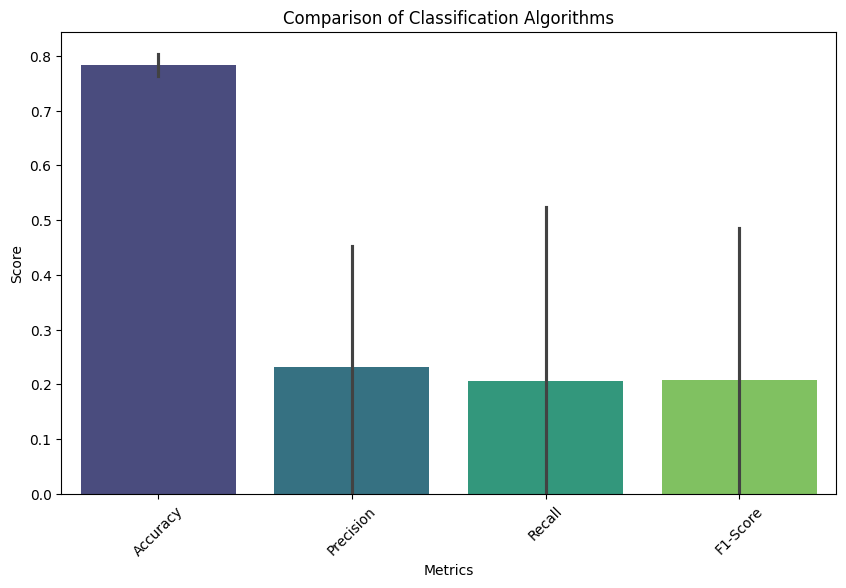

In [38]:
import pandas as pd

df = pd.read_csv('../Churn_Modelling.csv')
df = df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df_encoded = pd.get_dummies(df, columns = ['Geography'], drop_first = True)
df = df_encoded

numeric_columns = df.select_dtypes(include='number').columns

# Check for negative values
negative_values = (df[numeric_columns] < 0).sum()
if negative_values.sum() == 0:
    print('No negative values')

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print('No missing values')

# Check for invalid age values
invalid_age_values = (df['Age'] < 18) | (df['Age'] > 100)
if invalid_age_values.sum() == 0:
    print('No invalid age values')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with all features and target variable
# Define 'X' (features) and 'y' (target variable)
X = df.drop(columns=['Exited'])  # Assuming 'Exited' is the target variable
y = df['Exited']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC()
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = [accuracy, precision, recall, f1]

# Convert results to DataFrame for visualization
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, palette='viridis')
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()
